In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field

import nest_asyncio
nest_asyncio.apply()
from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo
from typing import List, Dict
import re
import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [3]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [6]:
all_nodes = handler.load_docs()

In [7]:
all_nodes

[TextNode(id_='2489352a-7c62-4272-8a19-0746ceb0f845', embedding=None, metadata={'Header_1': 'Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics', 'experimental_variable_entities': ['channelrhodopsin', 'optogenetics'], 'fig_refs': []}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='c2155598-52f8-4e4f-9b94-62149747c0b0', node_type=None, metadata={}, hash=None)}, text='Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics\n\nClaire N. Bedbrook<sup>1</sup>, Kevin K. Yang<sup>2,†</sup>, J. Elliott Robinson<sup>1,†</sup>, Elisha D. Mackey<sup>1</sup>, Viviana Gradinaru<sup>1,*</sup>, Frances H. Arnold<sup>1,2,*<

In [13]:
fig_num = 3

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

query_tool = handler.query_engine_tool(top_k=10, metadata_filters=filters)

In [14]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [15]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [16]:
response = query_tool(prompt)

In [17]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='fe1922e8-9dae-4172

In [18]:
figure_struct = output_parser.parse(response.content)

In [19]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 3
	Panel: b

		Plot: Microscope images
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Neuron morphology', categorical=False)]
	Panel: c

		Plot: Photocurrent bar graphs
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Light intensity', categorical=True)] dependent_variables=[Variable(name='Photocurrent', categorical=False)]
	Panel: d

		Plot: Spike fidelity vs Light intensity
			independent_variables=[Variable(name='Light intensity', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: e

		Plot: Spike fidelity vs Frequency
			independent_variables=[Variable(name='Frequency', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: f

		Plot: Voltage traces
			independent_variables=[Variable(n

In [20]:
panel = figure_struct.panels[2]
plot = panel.plots[0]
exp = plot.experiments[0]

class CategoricalVariable(BaseModel):
    name: str
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )
    values: dict[str, str] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting categorical labels from plots in scientific papers.
    You will always primarily look to the image of the figure.
    If the information is not available in the image, you can look to the text.
    You will always dummy check your answer by counting the number of expected labels in the image.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
        In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
    Return your answer as structured data.
        """
        
    else:
        var_cls = NumericVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given an numeric independent variable and a plot containing datapoints corresponding to that variable.
    Your job is to give the set of values for that variable for the markers in the the specific plot (not the whole figure). 
    You will always dummy check your answer by counting the number of expected datapoints in the plot.

    YOUR CURRENT TASK:

In Figure {fig_num}{panel.name}, plot title/description: {plot.name}, what set are the values of {iv.name} plotted across all data in the panel?
    IMPORTANT: 
        WE WANT TO MATCH THE FIGURE. USE THE TEXT TO HELP, BUT IF THERE IS A DISCREPANCY, RESOLVE ASSUMING THE IMAGE IS CORRECT.
        COUNT THE NUMBER OF POINTS OR LINES IN THE IMAGE TO ENSURE THAT YOU RETURN THE CORRECT NUMBER OF VALUES.
        THAT IS, DO NOT REPORT THE LOCATIONS OF AXIS TICKE MARKS OR TICK MARK LABELS, REPORT THE VALUES OF THE POINTS ON THE PLOT!!!
    Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    # response = query_tool(prompt)
    # text = response.content

    response = query_tool(prompt)
    text = response.content

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Light intensity' categorical=False
name='ChR variant' categorical=True


In [21]:
ivs_with_values

[NumericVariable(name='Light intensity', values=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], unit='mW mm^-2'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'ChRger1': 'pink', 'ChRger2': 'blue', 'ChRger3': 'green', 'CoChR': 'gray', 'ChR2': 'black'})]

In [22]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='fe1922e8-9dae-4172

In [23]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [40]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given a numeric dedependent variable and a plot containing data points which have values for that variable.
    Your job is to give values for the markers in the plot as a function of the provided independent variables.
    We want to match the data points in the plot EXACTLY - not just the shapes or trends.
    You will always dummy check your answer by counting the number of expected datapoints, lines, etc in the plot.
    When there is a discrepency between text and graphic, align your answer to the graphic.

In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = query_tool(prompt)
panel_df = output_parser.parse(data_response.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [41]:
data_response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='fe1922e8-9dae-4172

In [42]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
# chr_variant_names = [v for v in chr_variant_iv.values]
chr_variant_colors = [v for k,v in chr_variant_iv.values.items()]

# def get_color(color_name):
#     try:
#         return mcolors.to_rgba(color_name)
#     except ValueError:
#         # If the color name is not recognized, you can provide a fallback
#         return mcolors.to_rgba('gray')
    



In [43]:
import seaborn as sns

[]

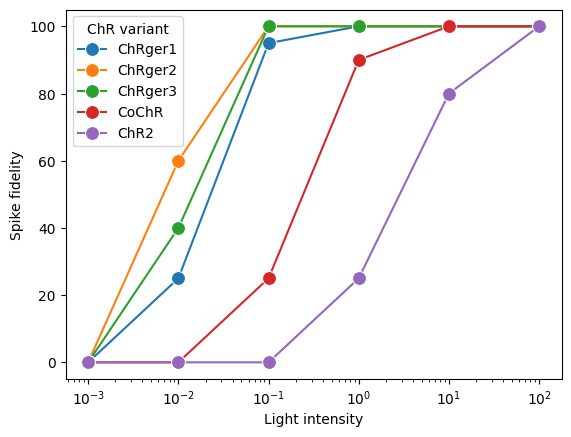

In [44]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [327]:
from PIL import Image

# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img = Image.open('plot.png')

In [328]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO

from plotreader.utils.base import BasicAnthropicLLM

claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")

for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response = claude_mm.message(prompt, images = [source_figure, generated_img])

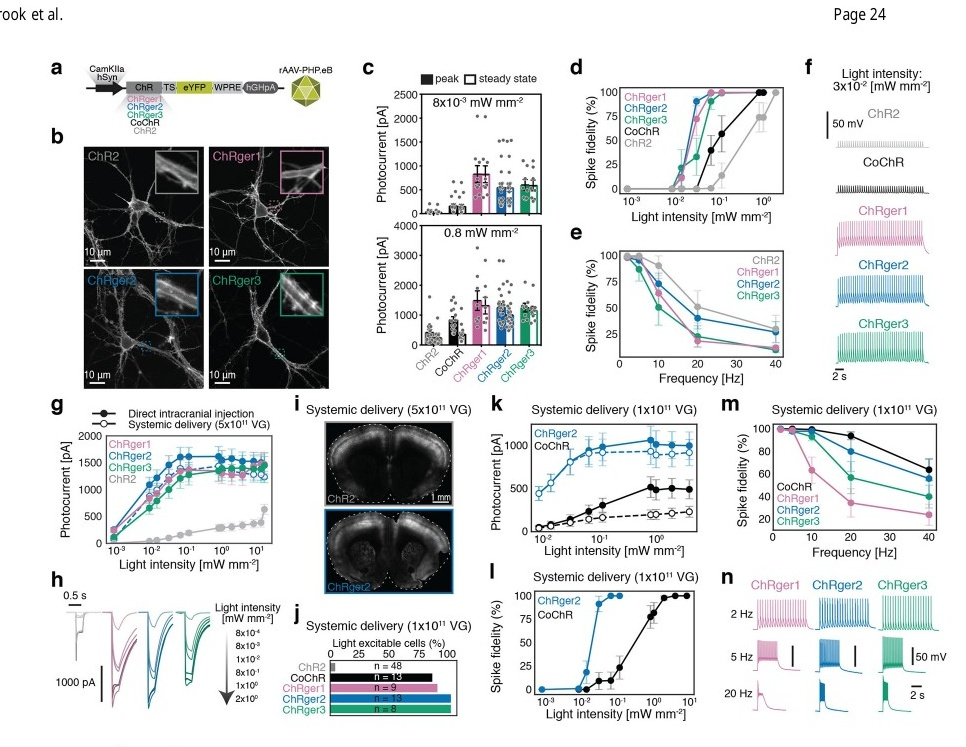

In [329]:
source_figure

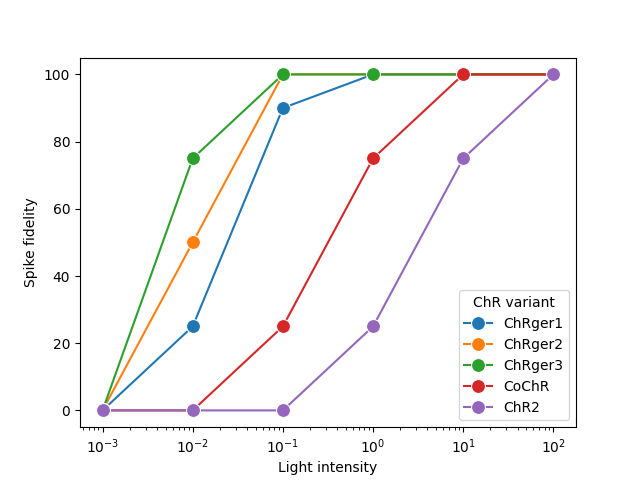

In [330]:
generated_img

In [331]:
print(response.content[0].text)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1, ChRger2, and ChRger3: In the source figure, these curves appear to be smoother and more sigmoidal, especially between 0.01 and 0.1 mW/mm². In the re-plotted data, these curves are more angular and abrupt. For example, ChRger3 in the re-plot jumps from 75% to 100% spike fidelity between 0.01 and 0.1 mW/mm², while in the original, it appears to have a more gradual increase.

2. CoChR performance at low light intensities: In the source figure, CoChR shows some activity (around 25% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm² and only starts showing activity (25%) at 0.1 mW/mm².

3. ChR2 performance at higher light intensities: In the source figure, ChR2 appears to reach close to 100% spike fidelity at 100 mW/mm². In the re-plotted data, ChR2 reaches exactly 100% at this intensity

In [332]:
feedback = response.content[0].text

In [351]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

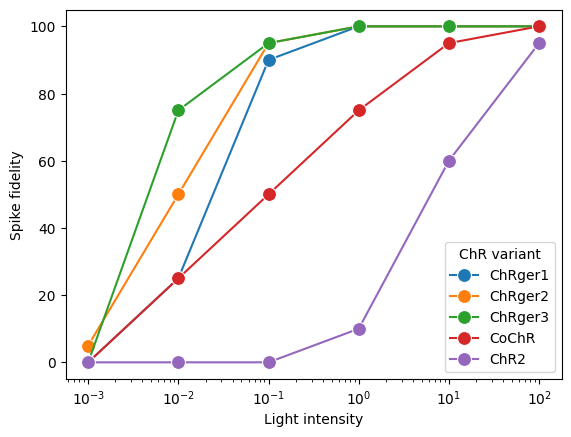

In [352]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [345]:
# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img_rev = Image.open('plot.png')

In [346]:


claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response_2 = claude_mm.message(prompt, images = [source_figure, generated_img_rev])

In [347]:
feedback_2 = response_2.content[0].text
print(feedback_2)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1: In the source figure, the ChRger1 curve (pink) shows a more gradual increase in spike fidelity between 0.01 and 0.1 mW/mm². However, in the re-plotted data, there's a sharp jump from 25% at 0.01 mW/mm² to 95% at 0.1 mW/mm². This difference significantly alters the shape of the curve for ChRger1 in the low light intensity range.

2. CoChR performance at low intensities: In the source figure, the CoChR curve (black) shows some activity (around 20-30% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm². This difference affects the interpretation of CoChR's sensitivity at low light intensities.

3. ChR2 curve shift: In the source figure, the ChR2 curve (gray) begins to rise noticeably around 1 mW/mm² and reaches about 50% spike fidelity at 10 mW/mm². In the re-plotted data, the ChR2 curv

In [364]:
panel_df

Light intensity ChR variant Spike fidelity
0             0.001     ChRger1              0
1             0.010     ChRger1              0
2             0.100     ChRger1             75
3             1.000     ChRger1            100
4            10.000     ChRger1            100
5           100.000     ChRger1            100
6             0.001     ChRger2              0
7             0.010     ChRger2             25
8             0.100     ChRger2            100
9             1.000     ChRger2            100
10           10.000     ChRger2            100
11          100.000     ChRger2            100
12            0.001     ChRger3              0
13            0.010     ChRger3             50
14            0.100     ChRger3            100
15            1.000     ChRger3            100
16           10.000     ChRger3            100
17          100.000     ChRger3            100
18            0.001       CoChR              0
19            0.010       CoChR              0
20            0.100       CoChR              0
21            1.000       CoChR             50
22           10.000       CoChR            100
23          100.000       CoChR            100
24            0.001        ChR2              0
25            0.010        ChR2              0
26            0.100        ChR2              0
27            1.000        ChR2              0
28           10.000        ChR2             75
29          100.000        ChR2            100

In [348]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback_2,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

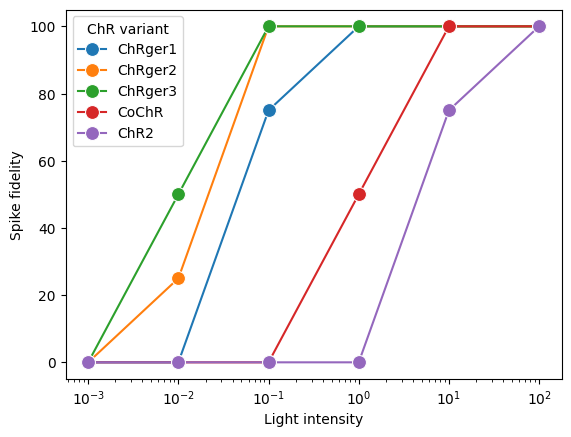

In [28]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [34]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO


In [35]:
for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

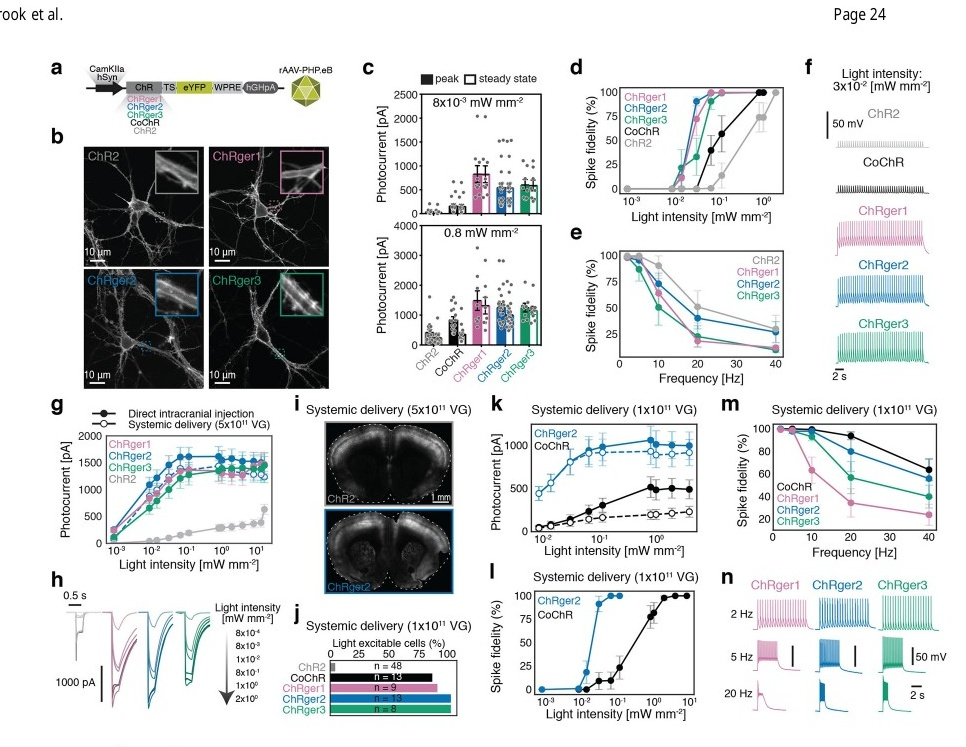

In [36]:
source_figure

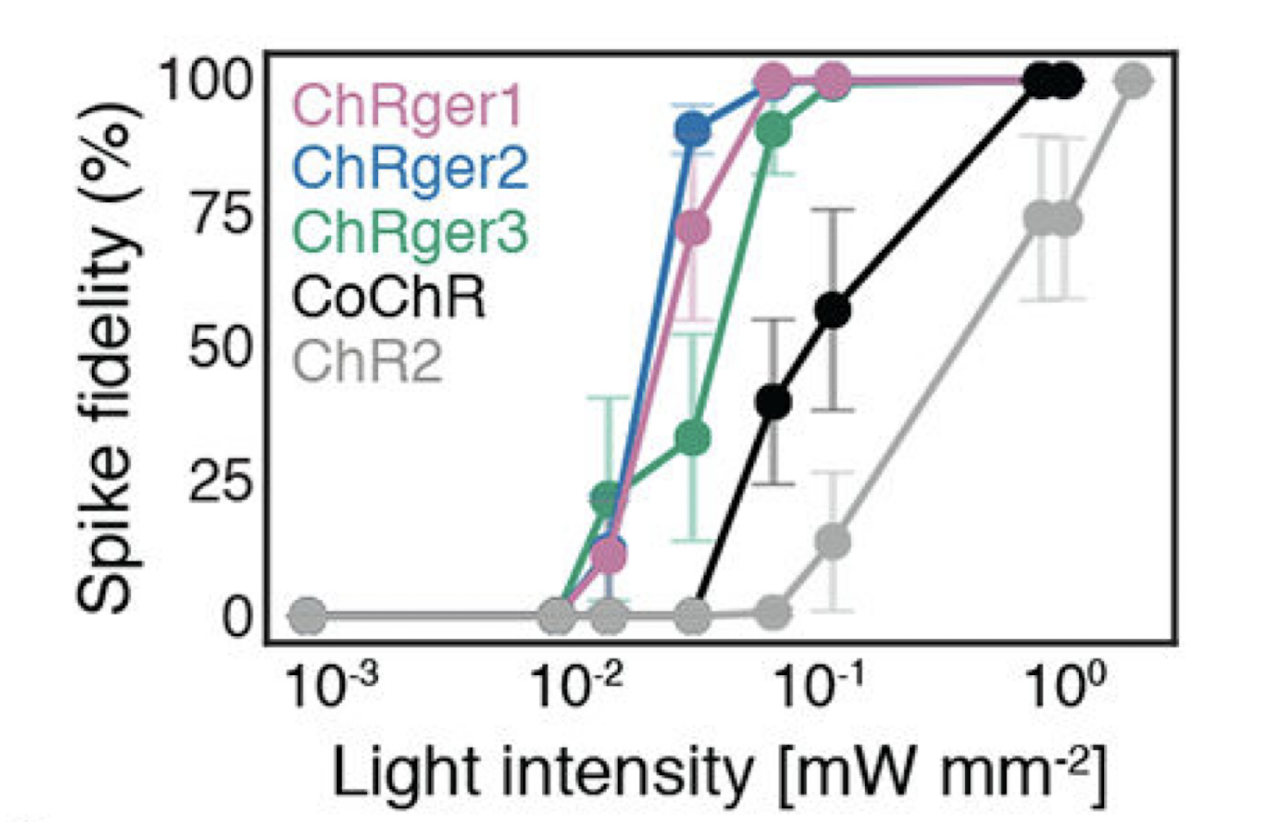

In [60]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
source_image = Image.open(source_panel)
source_image

Based on the comparison between the original figure and the recreated plot, here are three changes to improve the match:

1. Adjust the Spike fidelity values for ChRger3 at lower light intensities:
   - Change the Spike fidelity for ChRger3 at 0.01 Light intensity from 40 to about 20-25.
   - Change the Spike fidelity for ChRger3 at 0.1 Light intensity from 100 to about 30-35.
   This will correct the relative ordering of ChRger variants at lower light intensities.

2. Extend the Light intensity range:
   - Add data points for Light intensity values between 0.001 and 0.01, particularly for ChRger1, ChRger2, and ChRger3.
   - Add a data point for Light intensity at 0.003 for all variants to better capture the curve shapes.
   This will improve the resolution of the curves at lower light intensities.

3. Adjust the Spike fidelity values for CoChR:
   - Change the Spike fidelity for CoChR at 0.1 Light intensity from 25 to about 40.
   - Change the Spike fidelity for CoChR at 1 Light inten

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on comparing the original figure and the recreated plot, here are three key changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger2:
   - Decrease the Spike fidelity values for ChRger2 at lower Light intensities (0.003 and 0.01) to be below ChRger1.
   - For example, change ChRger2 at 0.003 from 20 to 5, and at 0.01 from 60 to 20.

2. Modify the range of Light intensity:
   - Change the maximum Light intensity from 100 to 1 mW mm^-2.
   - Remove the rows with Light intensity values of 10 and 100 for all ChR variants.

3. Adjust Spike fidelity values for CoChR:
   - Increase the Spike fidelity values for CoChR at higher Light intensities.
   - For example, change CoChR at 0.1 from 40 to 60, and at 1 from 60 to 100.

These changes will help align the recreated plot more closely with the original figure, addressing the relative ordering of variants, the x-axis range, and specific data point values.


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on comparing the original figure and the recreated plot, here are three key changes to improve the match:

1. Adjust the relative ordering of ChRger variants:
   - ChRger2 should have higher spike fidelity than ChRger1 at lower light intensities (0.001 to 0.01 mW mm^-2)
   - ChRger3 should have lower spike fidelity than ChRger1 and ChRger2 at mid-range light intensities (around 0.1 mW mm^-2)

2. Extend the range of light intensity values:
   - Add data points for light intensities between 0.1 and 1 mW mm^-2 (e.g. 0.3 mW mm^-2) for all variants
   - This will better capture the curves' shapes, especially for CoChR and ChR2

3. Adjust spike fidelity values for CoChR:
   - Increase spike fidelity for CoChR at 0.1 mW mm^-2 to around 80-90%
   - Add intermediate points to show a steeper rise in spike fidelity between 0.01 and 0.1 mW mm^-2

These changes will help align the recreated plot more closely with the original figure, improving the accuracy of the data representation and the r

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger3 at lower Light intensities. The original plot shows ChRger3 having lower Spike fidelity than ChRger1 and ChRger2 at Light intensities between 0.01 and 0.1. In the extracted data, reduce the Spike fidelity values for ChRger3 at these Light intensities to better match the relative ordering in the original plot.

2. Increase the Spike fidelity values for ChR2 at higher Light intensities. In the original plot, ChR2 reaches about 75% Spike fidelity at the highest Light intensity (1.0). In the extracted data, increase the Spike fidelity values for ChR2 at Light intensities 0.3 and 1.0 to better match the range shown in the original plot.

3. Add more data points for all ChR variants, especially in the Light intensity range between 0.01 and 0.1. The original plot shows smoother curves with more d

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on comparing the original figure and the recreated plot, here are three key changes to improve the match:

1. Adjust the relative ordering of ChRger3 and CoChR:
   The extracted data shows ChRger3 having higher spike fidelity than CoChR at lower light intensities, but the original figure shows the opposite. Decrease the spike fidelity values for ChRger3 at lower light intensities (e.g. 0.001 to 0.03 mW/mm^2) and increase the values for CoChR in this range.

2. Extend the range of light intensity for ChR2:
   In the original figure, ChR2 has non-zero spike fidelity values starting from around 0.1 mW/mm^2. Add more data points for ChR2 between 0.1 and 1 mW/mm^2 to better capture its curve shape and maximum spike fidelity (which appears to be around 75-80% at 1 mW/mm^2).

3. Adjust the spike fidelity values for ChRger1 and ChRger2:
   The extracted data shows these two variants reaching 100% spike fidelity, but in the original figure they appear to max out slightly below 100%. Reduc

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on comparing the extracted data plot to the original figure, here are three key changes to improve the match:

1. Adjust the relative ordering of ChRger3 and CoChR curves:
   The extracted data shows ChRger3 having lower spike fidelity than CoChR at most light intensities, but the original figure shows ChRger3 having higher spike fidelity than CoChR, especially at higher light intensities. Increase the spike fidelity values for ChRger3 to be higher than CoChR at light intensities above 0.02 mW/mm^2.

2. Extend the range of light intensity values for ChR2:
   In the extracted data, ChR2 only has values up to 1 mW/mm^2, but the original figure shows data points extending beyond 1 mW/mm^2. Add additional rows for ChR2 with light intensity values up to 3 or 5 mW/mm^2 to match the original figure's x-axis range.

3. Adjust the spike fidelity values for ChRger1 and ChRger2:
   The extracted data shows ChRger2 consistently having higher spike fidelity than ChRger1, but the original figu

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger2: The original figure shows ChRger1 slightly outperforming ChRger2 at higher light intensities, while the recreated plot shows the opposite. To fix this, increase the Spike fidelity values for ChRger1 slightly at higher light intensities (e.g., 0.1 to 1 mW mm^-2) and/or decrease the values for ChRger2 slightly in the same range.

2. Extend the range of Light intensity for ChR2: In the original figure, ChR2 data points extend to higher light intensities than the other variants. Add more rows for ChR2 with Light intensity values up to 5 mW mm^-2, as shown in the original figure.

3. Adjust the Spike fidelity values for CoChR: The recreated plot shows CoChR performing better than ChRger3 at lower light intensities, which is not consistent with the original figure. Decrease the Spike fid

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 to be lower than ChRger1 at higher Light intensities. Currently, ChRger2 appears to have higher Spike fidelity than ChRger1 in the recreated plot, which is inconsistent with the original figure. This change addresses the relative ordering of quantities in the plot.

2. Increase the maximum Light intensity value for ChR2 to 10 or higher. In the original figure, the ChR2 curve extends further to the right than in the recreated plot. This change affects the range of the data.

3. Add more data points for ChR2 at lower Light intensities (between 0.001 and 0.1) to better represent the initial flat portion of the curve seen in the original figure. This change addresses the number of rows of data for the independent variable.

These changes should help make the recreated plot more closely match t

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 to be lower than ChRger1 at higher Light intensities. Currently, ChRger2 and ChRger1 are very close, but in the original figure, ChRger1 clearly reaches higher Spike fidelity values than ChRger2 at higher Light intensities.

2. Reduce the Spike fidelity values for ChRger3 at lower Light intensities. In the original figure, ChRger3 starts increasing later than in the recreated plot. For example, at Light intensity 0.01, ChRger3 should have a lower Spike fidelity value, closer to 0%.

3. Extend the Light intensity range for ChR2 to higher values. In the original figure, the ChR2 curve continues beyond the 1 mW mm^-2 mark, reaching close to 100% Spike fidelity. Add more data points for ChR2 at higher Light intensity values (e.g., 2, 3, 5, 10 mW mm^-2) to match the full curve shown in the orig

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger2: In the original figure, ChRger1 shows higher spike fidelity than ChRger2 at higher light intensities. In the extracted data, this should be reflected by increasing the spike fidelity values for ChRger1 at higher light intensities (e.g., 0.1, 0.3, and 1 mW mm^-2) to be slightly above those of ChRger2.

2. Extend the range of light intensity for ChR2: In the original figure, the ChR2 curve extends to higher light intensities than the other variants. Add more data points for ChR2 at higher light intensities (e.g., 2, 3, 5, and 10 mW mm^-2) to match the original figure's x-axis range.

3. Adjust the spike fidelity values for CoChR: In the original figure, the CoChR curve rises more steeply and reaches higher spike fidelity values at lower light intensities compared to the recreated plo

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on comparing the extracted data plot to the original figure, here are three key changes to improve the match:

1. Adjust the relative ordering of ChRger2 and ChRger1: In the original figure, ChRger2 shows higher spike fidelity than ChRger1 at lower light intensities, but ChRger1 surpasses ChRger2 at higher intensities. The extracted data should be modified to reflect this crossover.

2. Extend the range of light intensity for ChR2: In the original figure, ChR2 data points extend to higher light intensities (up to 10 mW mm^-2) compared to the other variants. The extracted data for ChR2 should include more data points at higher light intensities to match this range.

3. Adjust the spike fidelity values for ChRger3: In the original figure, ChRger3 shows lower spike fidelity than ChRger2 and ChRger1 at most light intensities, but reaches similar maximum values. The extracted data for ChRger3 should be modified to show lower spike fidelity values at intermediate light intensities whil

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 to be lower than ChRger1 at higher Light intensities. Currently, ChRger2 and ChRger1 are very close, but in the original figure, ChRger1 clearly reaches higher Spike fidelity values. This addresses the relative ordering of quantities in the plot.

2. Reduce the Spike fidelity values for ChRger3 at lower Light intensities (below 0.02). In the original figure, ChRger3 starts rising later than in the recreated plot. This change affects the range of the data for ChRger3.

3. Add more data points for ChR2 at higher Light intensities (between 1 and 10). The original figure shows more points in this range, which would help to better represent the curve for ChR2. This change addresses the number of rows of data for the ChR2 variant.

These changes should help make the recreated plot more closely m

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 to be lower than ChRger1 at higher Light intensity values. Currently, ChRger2 and ChRger1 are too close in the recreated plot, while in the original figure, ChRger1 clearly reaches higher Spike fidelity values.

2. Increase the Light intensity range for ChR2. In the original figure, ChR2 extends further to the right on the x-axis, reaching higher Light intensity values (up to 10 mW mm^-2). Add more data points for ChR2 at higher Light intensity values, up to 10.

3. Adjust the Spike fidelity values for CoChR to start increasing at lower Light intensity values. In the original figure, the CoChR curve starts rising earlier than in the recreated plot. Modify the Spike fidelity values for CoChR at lower Light intensity values (around 0.01-0.02) to better match the original figure.

These chang

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger3 at lower Light intensities. The original plot shows ChRger3 having 0% Spike fidelity up to about 0.01 mW mm^-2, while the extracted data shows some non-zero values. Change the Spike fidelity values for ChRger3 at Light intensities 0.001, 0.003, 0.005, and 0.01 to 0.

2. Modify the Spike fidelity values for CoChR to better match its position relative to other variants. In the original plot, CoChR's curve is between ChRger3 and ChR2, but in the recreated plot, it's closer to ChRger1 and ChRger2. Decrease the Spike fidelity values for CoChR across all Light intensities to shift its curve to the right.

3. Extend the Light intensity range for ChR2 to higher values. The original plot shows data points for ChR2 up to 10 mW mm^-2, while the extracted data only goes up to 1 mW mm^-2. Add more rows

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 to be lower than ChRger1 across the entire range of Light intensity. Currently, ChRger2 shows higher Spike fidelity at lower Light intensities, which doesn't match the original figure.

2. Increase the maximum Light intensity value for ChR2 to 10 mW mm^-2. The extracted data currently only goes up to 1 mW mm^-2 for ChR2, but the original figure shows data points beyond this value.

3. Adjust the Spike fidelity values for CoChR to be lower, especially in the mid-range of Light intensity (around 0.01 to 0.1 mW mm^-2). The current data shows CoChR performing better than it does in the original figure relative to the other variants.

These changes address the relative ordering of the ChR variants, extend the range of data for ChR2, and adjust values across multiple rows to better match the ori

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger3 to be higher than CoChR at lower Light intensities. Currently, CoChR shows higher Spike fidelity than ChRger3 at lower intensities, which doesn't match the original figure. This change will fix the relative ordering of these two variants.

2. Extend the Light intensity range for ChR2 up to 10 mW mm^-2. The original figure shows data points for ChR2 extending further to the right than the other variants. Add more rows of data for ChR2 with Light intensity values up to 10.

3. Reduce the Spike fidelity values for ChRger2 at lower Light intensities. In the original figure, ChRger2 starts increasing later than ChRger1, but in the recreated plot, it starts increasing earlier. Adjust the values for ChRger2 at Light intensities between 0.001 and 0.01 to be lower.

These changes will help make the

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three key changes to improve the match:

1. Adjust the relative ordering of ChRger2 and ChRger3:
   In the original figure, ChRger2 (second from top) shows higher spike fidelity than ChRger3 (third from top) at lower light intensities. In the extracted data, this ordering should be swapped. Increase the spike fidelity values for ChRger2 at lower light intensities (e.g., 0.01-0.05 mW mm^-2) and decrease them for ChRger3 in the same range.

2. Extend the range of light intensity for ChR2:
   In the original figure, ChR2 data points extend to higher light intensities (up to 10^1 mW mm^-2). Add more data points for ChR2 at higher light intensities (e.g., 2, 3, 5, 7, 10 mW mm^-2) to match the original figure's x-axis range.

3. Adjust the spike fidelity values for CoChR:
   In the original figure, CoChR (fourth from top) shows lower spike fidelity than in the extracted data, especially at mid-range light in

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger3 to be higher than ChRger1 and ChRger2 at lower Light intensity values (around 0.01-0.02 mW mm^-2). This will fix the relative ordering of the curves at lower light intensities.

2. Extend the Light intensity range for ChR2 to higher values, up to 10 mW mm^-2. The original plot shows data points for ChR2 extending further to the right than the other variants.

3. Reduce the Spike fidelity values for CoChR across all Light intensity values. In the original plot, the CoChR curve is consistently lower than the ChRger variants, but in the recreated plot, it overlaps with ChRger3 at higher light intensities.

These changes will help to better match the relative positions and shapes of the curves in the original figure, improving the overall accuracy of the recreated plot.


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three key changes to improve the match:

1. Adjust the relative ordering of ChRger variants:
   The original figure shows ChRger2 having higher spike fidelity than ChRger1 at lower light intensities, while ChRger1 surpasses ChRger2 at higher intensities. In the extracted data, ChRger1 consistently has higher values. Modify the spike fidelity values for ChRger1 and ChRger2 to reflect this crossover behavior.

2. Extend the range of light intensity for ChR2:
   In the original figure, ChR2 data points extend to higher light intensities (up to 10^0 mW mm^-2) compared to other variants. Add more data points for ChR2 at higher light intensities (e.g., 2, 3, 5, 7, 10 mW mm^-2) to match the original plot's x-axis range.

3. Adjust the spike fidelity values for CoChR:
   The extracted data for CoChR shows higher spike fidelity values than what appears in the original figure, especially at lower light intensiti

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are three changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 to be higher than ChRger1 at lower Light intensity values. Currently, ChRger1 shows higher Spike fidelity at some lower intensities, which doesn't match the original figure where ChRger2 consistently outperforms ChRger1.

2. Decrease the Spike fidelity values for ChRger3 across all Light intensity values. In the original figure, ChRger3 has a noticeably lower curve compared to ChRger1 and ChRger2, but in the recreated plot, it's too close to them.

3. Extend the Light intensity range for ChR2 up to 10 mW mm^-2, as shown in the original figure. The current data only goes up to 1 mW mm^-2 for ChR2, missing the higher intensity values present in the original plot.

These changes will help to better align the recreated plot with the original figure, improving the relative ordering of the ChR v

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)
/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_63873/3984545450.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots()


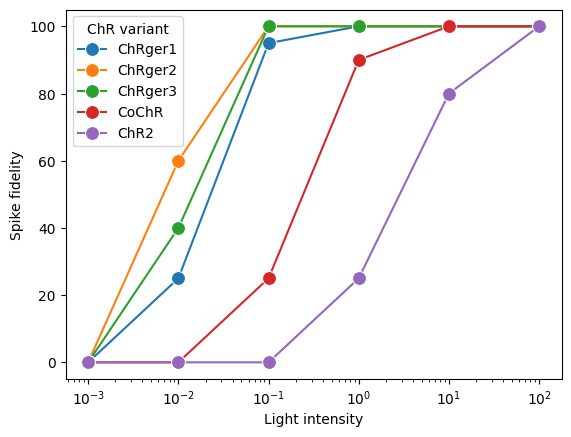

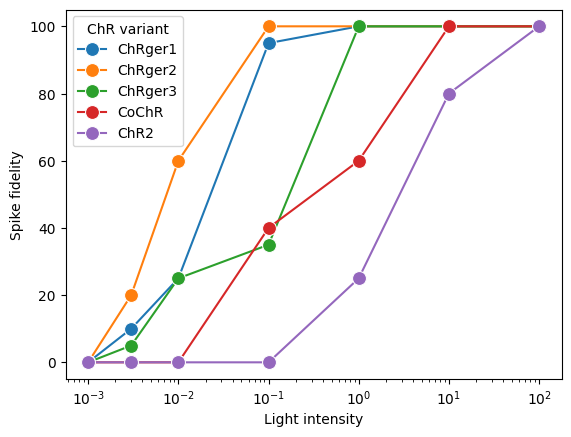

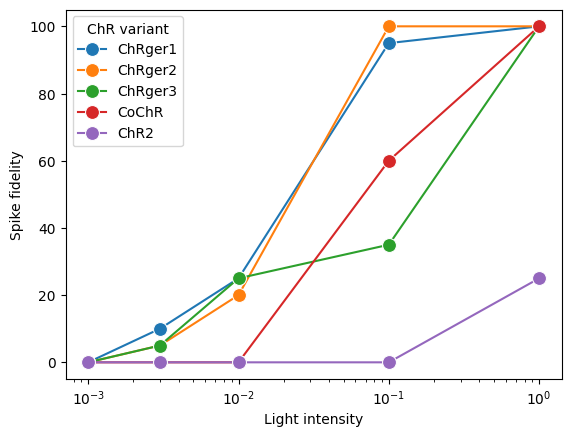

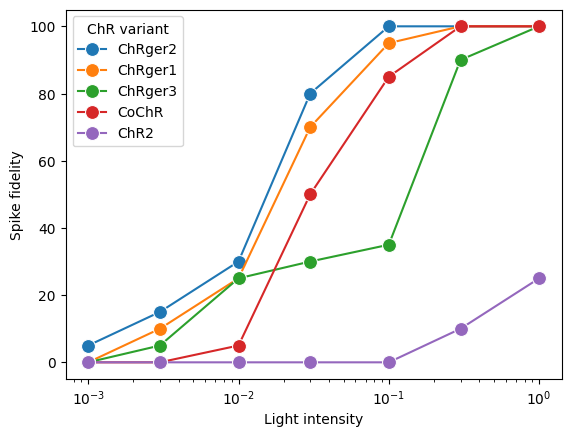

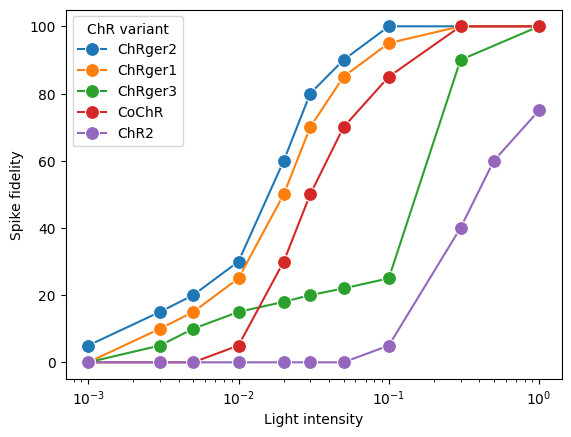

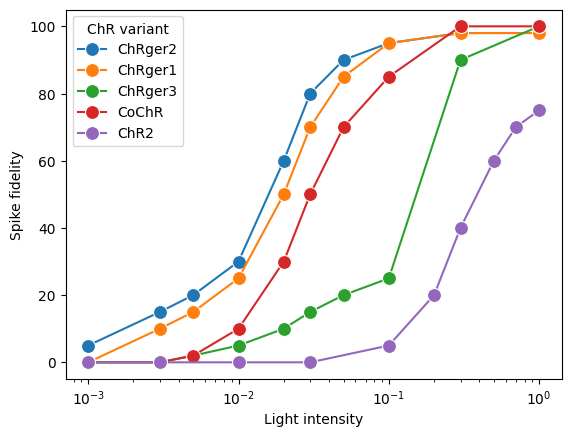

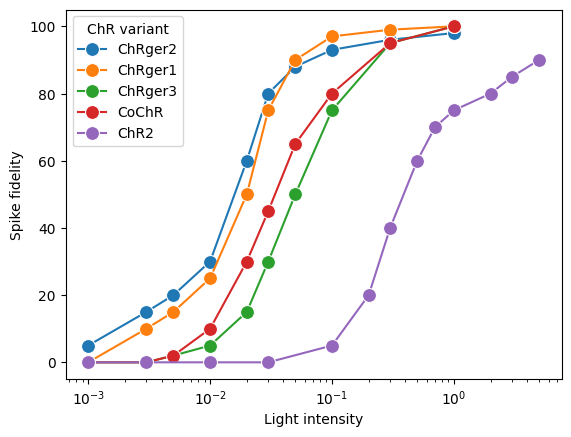

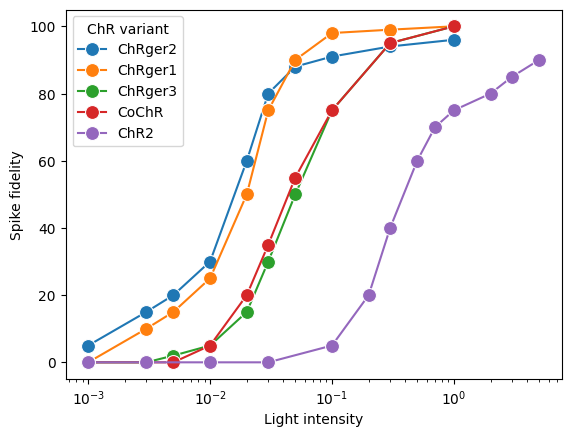

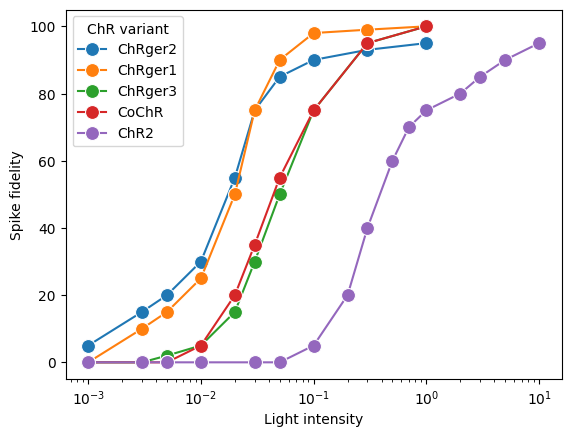

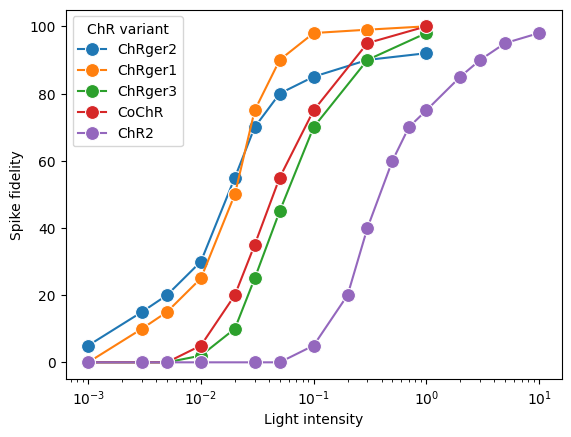

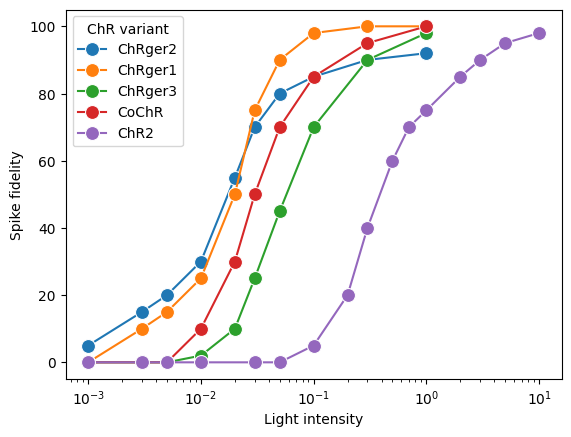

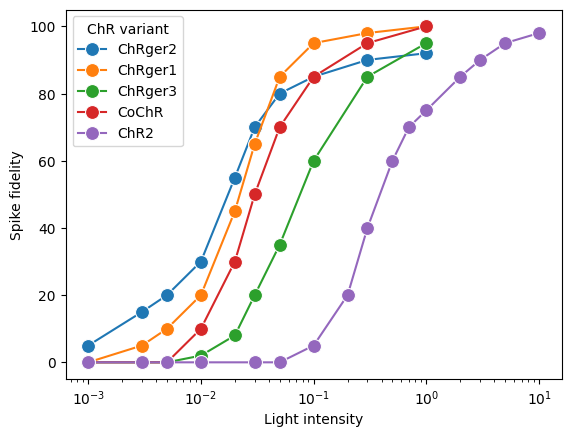

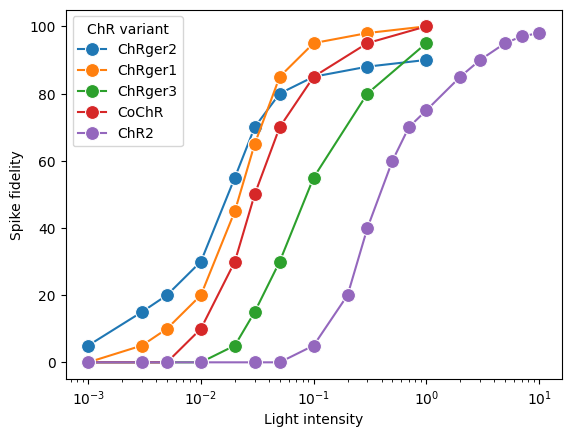

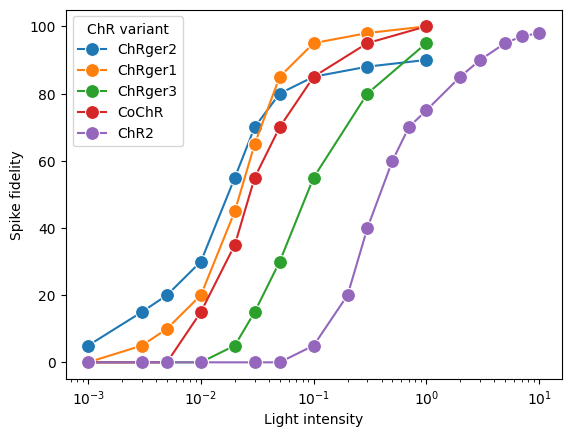

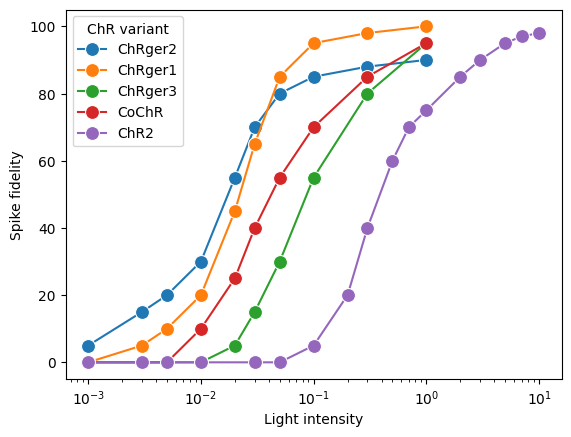

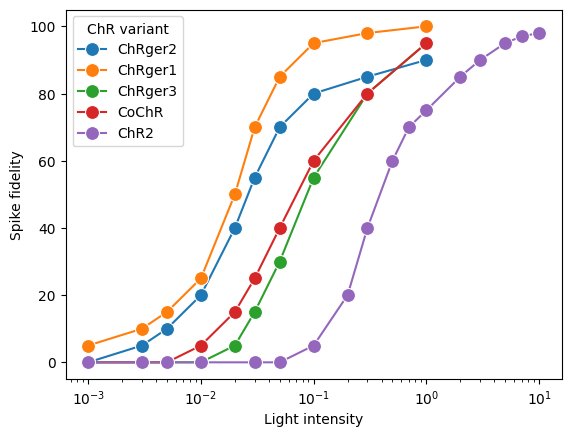

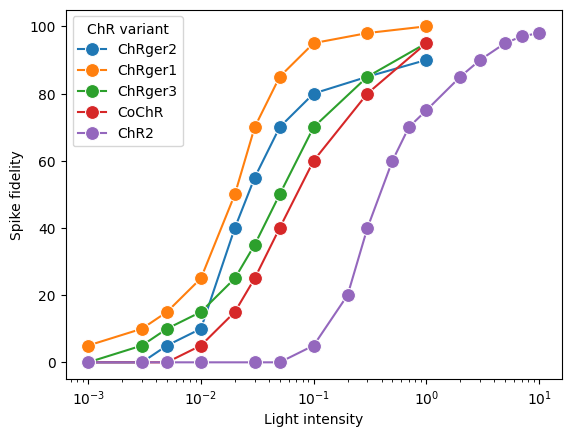

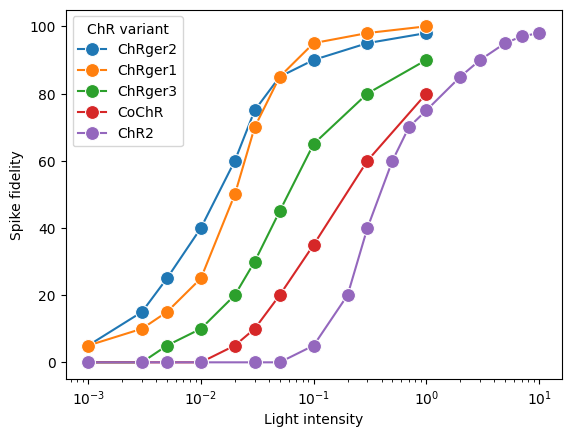

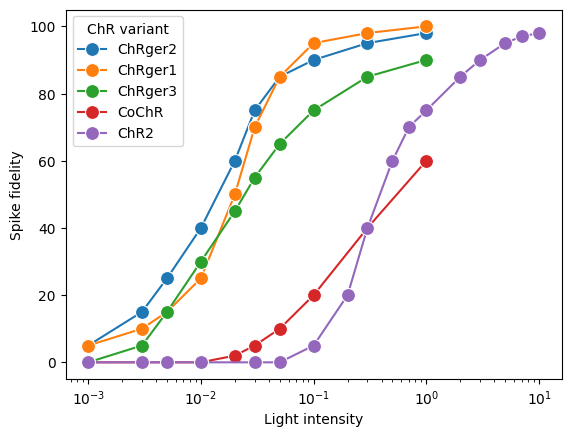

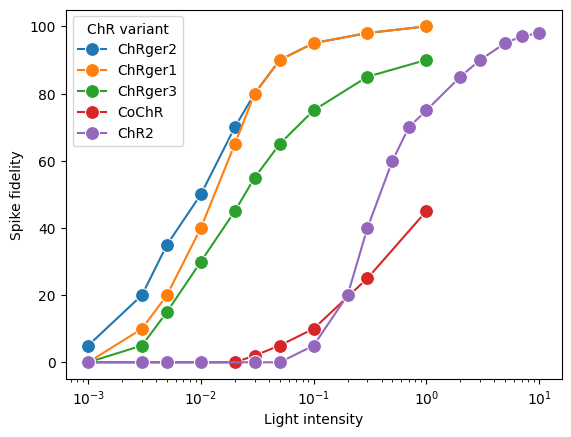

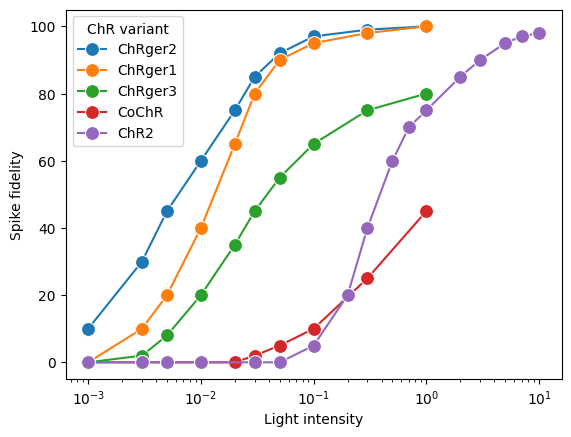

In [64]:
from matplotlib import pyplot as plt
from PIL import Image

fig, axes = plt.subplots()
sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    ax=axes
)
axes.semilogx()

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

for iter in range(20):




    claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


    prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
Given the full source figure and a recreation of the target plot from the extracted data, list three changes to make to the extracted data to improve the match.
You can efer to specific variable names, but do not reference colors!

Suggest changes according to the following priority:
1. changes that fix the relative ordering of quantities in the plot
1. changes to the range of the data (e.g. min and max values for a variable)
2. changes to the number of rows of data (e.g. missing values for independent variables)
3. changes that affect the values of many rows at a time

Extracted data used to generate recreated plot:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm.message(prompt, images = [source_image, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
We are extracting a dataframe containing the values of the data points in Figure {fig_num}{panel_name}, plot {plot_name}.
To validate that extraction, we have replotted the points and analyzed the differences. Can you help us use this analysis to improve the extracted dataframe?

Here is you the previous extracted data:
{df_table}

Here are changes based on comparing the extracted data to the source figure:
{feedback}

Please revise the dataframe by making these changes.

Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
    ).replace("{","<").replace("}",">")

    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = query_tool(prompt)
    panel_df_loop = output_parser.parse(data_response_loop.content).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    sns.lineplot(
        data=panel_df_loop,
        x='Light intensity',
        y='Spike fidelity',
        hue='ChR variant',
        marker='o',
        # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
        markersize=10,
        ax=axes
    )
    axes.set_xscale('log')  # Set x-axis to logarithmic scale

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

In [401]:
print(prompt)


    YOUR OVERALL JOB:
        You were previously given the following task:

            In Figure 2d, plot Spike fidelity vs Light intensity, what are the values for the dependent variable Spike fidelity?
            And you were asked to return you data in a DataFrame and were provided with information about the independent variables and their values for this plot.

        Here is you the dataframe output from your previous response:
        |    |   Light intensity | ChR variant   |   Spike fidelity |
|---:|------------------:|:--------------|-----------------:|
|  0 |             0.001 | ChRger1       |                0 |
|  1 |             0.003 | ChRger1       |                0 |
|  2 |             0.01  | ChRger1       |               10 |
|  3 |             0.03  | ChRger1       |               40 |
|  4 |             0.06  | ChRger1       |               80 |
|  5 |             0.1   | ChRger1       |               95 |
|  6 |             0.3   | ChRger1       |            

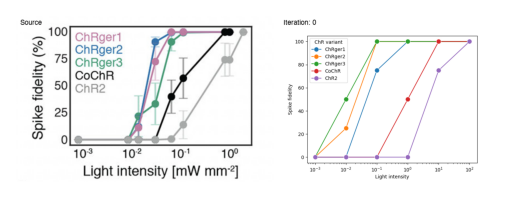

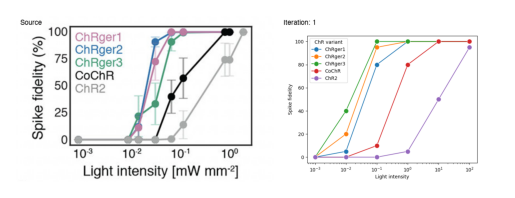

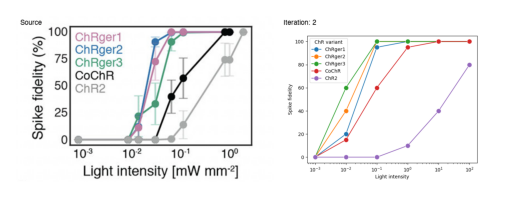

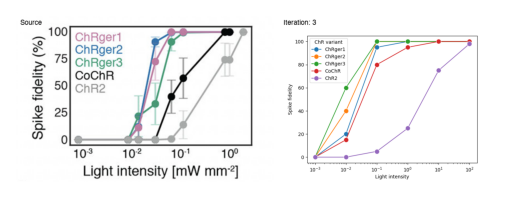

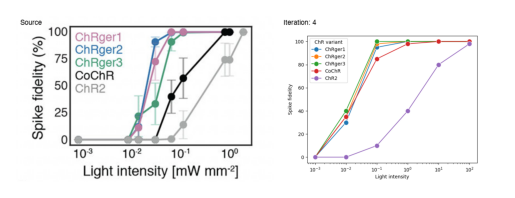

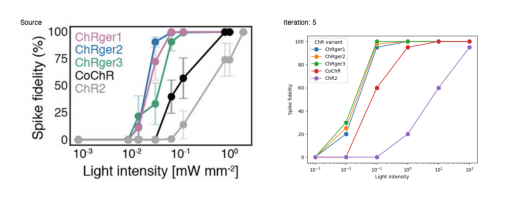

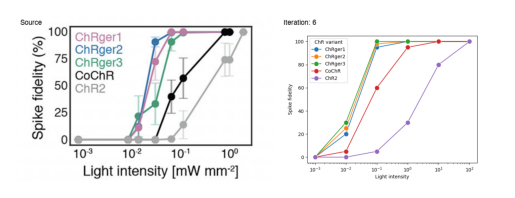

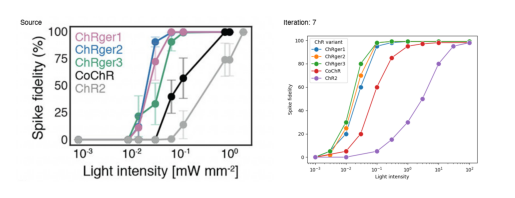

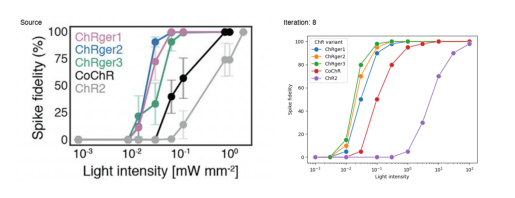

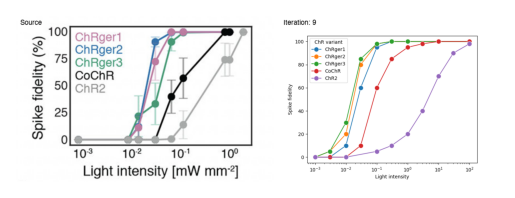

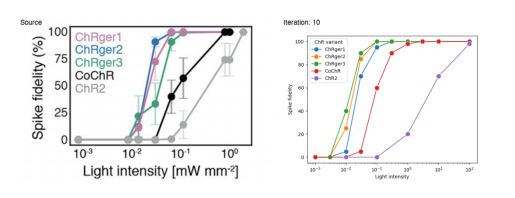

MP4 video saved as 'comparison.mp4'


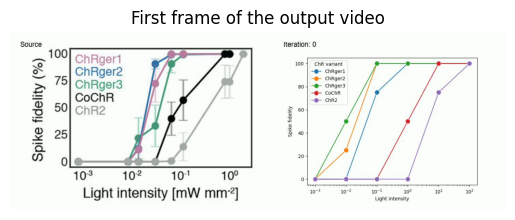

In [ ]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(11):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")


/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_39940/1437840151.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


[]

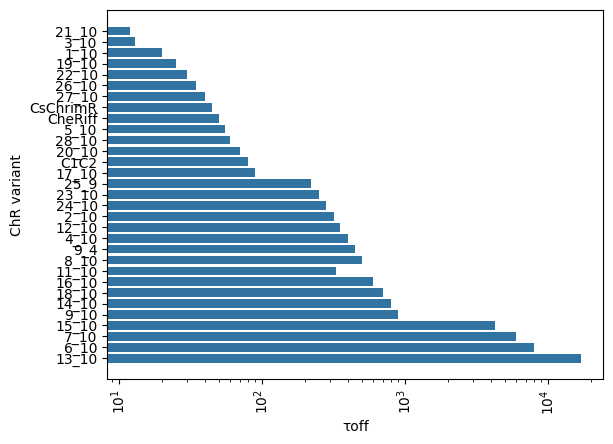

In [27]:
# panel_df_adjusted = panel_df.copy()
# panel_df_adjusted['τoff'] *= 1000

# horizontal bar plot
axes = sns.barplot(
    data=panel_df,
    x='τoff',
    y='ChR variant',
    orient='h',
)
# axes = sns.barplot(
#     data=panel_df,
#     x='ChR variant',
#     y='τoff',
# )
# rotate x-tick labels 90 deg
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.semilogx()



<Axes: xlabel='Wavelength', ylabel='Normalized photocurrent'>

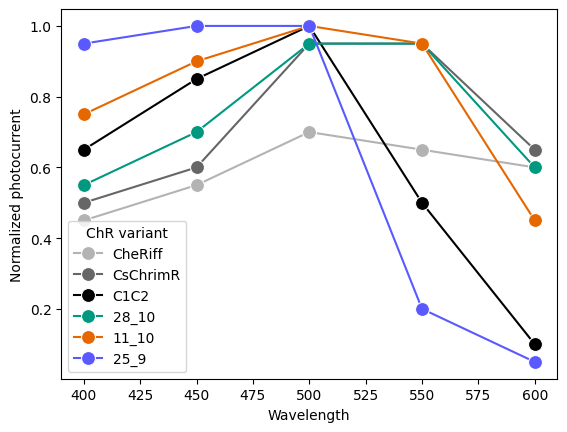

In [127]:


sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    palette=[[0.7, 0.7, 0.7], [0.4, 0.4, 0.4], [0, 0, 0], [0, .6 , .5], [0.9, 0.4, 0.0], [0.35, 0.35, 1.0]]
)
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [23]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [40]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import MetadataMode

In [42]:
for node in retrieverd_nodes[:-1]:
    try:
        display_source_node(node, source_length=100000)
    except:
        print(node)

**Node ID:** 7cf5ee59-0e97-445f-8884-f4e21f7bba21<br>**Similarity:** 0.40960259534169907<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents. (continued)<br>

**Node ID:** 5cb68f1f-e64c-4502-9da2-c42717a765e2<br>**Similarity:** 0.4057491962557034<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.<br>

**Node ID:** d04f54e0-29ba-4046-92a6-7d2c6e9268f0<br>**Similarity:** 0.3793601396922902<br>**Text:** Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.

Section a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_10 in purple, and 3_10 in red. The bottom row shows fluorescence images of ChR expression in HEK cells, with a 20 μm scale bar.

Section b displays measured peak and steady-state photocurrent with different wavelengths of light in HEK cells (n=4-8 cells, see Dataset 2). Four wavelengths are shown: 397 nm, 481 nm, 546 nm, and 640 nm. The y-axis shows photocurrent in pA, with different scales for each wavelength. Peak currents are represented by dark gray bars, while steady-state currents are in light gray. Error bars are included.

Section c shows off-kinetics decay rate (τoff) following a 1 ms exposure to 481 nm light at 2.3 mW mm^2 (n=4-8 cells, see Dataset 2). Parent ChRs are highlighted in light gray. The x-axis shows τoff values on a logarithmic scale from 10^1 to 10^4 ms. Inset shows representative current traces with 1 ms light exposure for select ChRs revealing distinct profiles: ChR_21_10 (purple) turns off rapidly, ChR_3_10 (red) and ChR_25_9 (light blue) turn off more slowly, and ChR_15_10 (blue) exhibits little decrease in photocurrent 0.5 s after the light exposure. The time scale for these traces is 100 ms.

Section d shows normalized photocurrent as a function of wavelength for various ChR variants. The wavelengths range from 400 nm to 600 nm. Different colored lines represent different ChR variants, corresponding to the colors in panel a.

Section e displays peak photocurrent (left) and steady-state photocurrent (right) as a function of light intensity for various ChR variants. The x-axis shows light intensity from 10^-1 to 10^1 mW mm^-2 on a logarithmic scale. The y-axis shows photocurrent in pA, up to 2500 pA. Different colored lines represent different ChR variants, corresponding to the colors in panel a. Error bars are included.<br>**Image:**

**Node ID:** 22d9ee84-5d29-4f92-8527-e0ae97939355<br>**Similarity:** 0.36910398090655805<br>**Text:** Selection of designer ChRs using trained models<br>

**Node ID:** 5bbfd688-9a2b-439b-a86b-c786e9c193e7<br>**Similarity:** 0.35990217183769474<br>**Text:** Light delivery and imaging<br>

In [47]:
index_node = node.node

In [49]:
index_node.

'Light delivery and imaging'